# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import sys
import time

train_file = 'traffic-signs-data/train.p'
test_file = 'traffic-signs-data/test.p'
signnames_file = 'signnames.csv'

train_preprocessed_file = "traffic-signs-data/train_preprocessed.p"
test_preprocessed_file = "traffic-signs-data/test_preprocessed.p"

train_augmented_file = "traffic-signs-data/train_augmented.p"

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
with open(signnames_file, newline='') as f: 
    reader = csv.DictReader(f)
    signnames = []
    i = 0
    for row in reader:
        assert(int(row['ClassId']) == i)
        signnames.append(row['SignName'])
        i += 1
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# How many unique classes/labels there are in the dataset.
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

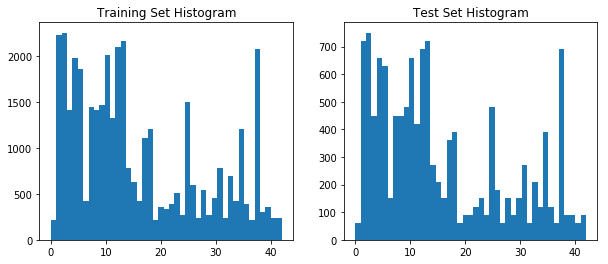

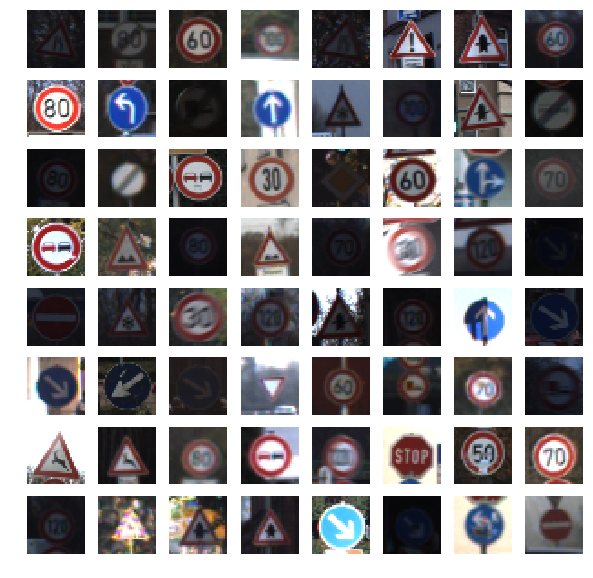

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_image(image, ax):
    y, x, c = image.shape
    ax.set_axis_off()
    if c == 1:
        imgplot = ax.imshow(image.reshape(y,x), cmap='gray')          
    elif c == 3:
        imgplot = ax.imshow(image)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return imgplot
    

def plot_random_images(images, images2=None):
    fig, axes = plt.subplots(8,8, figsize=(10,10))
    
    for i , ax in enumerate(axes.flat):
        plot_image(random.choice(images), ax)
        
    plt.show()

def plot_random_related_images(original, sided):
    fig, axes = plt.subplots(8,8, figsize=(10,10))
    
    index = 0
    images = []
    
    for i , ax in enumerate(axes.flat):
        if i % 2:
            images = sided
        else:
            index = random.randrange(original.shape[0])
            images = original
            
        plot_image(images[index], ax)
        
    plt.show()
    
fig = plt.figure(figsize=(10,4))
a=fig.add_subplot(1,2,1)
a.hist(y_train, n_classes, normed=0)
a.set_title("Training Set Histogram")
a=fig.add_subplot(1,2,2)
a.hist(y_test, n_classes, normed=0)
a.set_title("Test Set Histogram")
plt.show()

plot_random_images(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

def print_progress(step, total):
    percentage = int(100 * (step / float(total)))
    print("\r |{:-<100}| {:.0f}%".format('█' * percentage, percentage), end='')
    if step == total: 
        print()
        sys.stdout.flush()

def preprocess_color(images):
    
    X = np.copy(images)

    n_samples = X.shape[0]
    print("Preprocessing dataset with {} samples:".format(n_samples))
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    print_progress(0, n_samples)

    for i in range(n_samples):
        
        X[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2YUV)

        # equalize the histogram of the Y channel
        X[i,:,:,0] = clahe.apply(X[i,:,:,0])

        # convert the YUV image back to RGB format
        X[i] = cv2.cvtColor(X[i], cv2.COLOR_YUV2RGB)
        
        print_progress(i+1,n_samples)

    return X

def preprocess_gray(images):
    
    X = np.copy(images)
    n_samples = X.shape[0]
    print("Preprocessing dataset with {} samples:".format(n_samples))
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    print_progress(0, n_samples)

    for i in range(n_samples):
        
        X[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2YUV)

        # equalize the histogram of the Y channel
        X[i,:,:,0] = clahe.apply(X[i,:,:,0])

        print_progress(i+1,n_samples)
    
    # Get rid of UV components
    X = X[:,:,:,0]
    # Add the Y component as new dimension to the image of length 1 
    X = X.reshape(X.shape + (1,)) 
    return X

def normalize(images):
    # Normalize to keep values in the [0, 1] range
    return images.astype(np.float32) / 255.0

Preprocessing dataset with 39209 samples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Preprocessing dataset with 12630 samples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


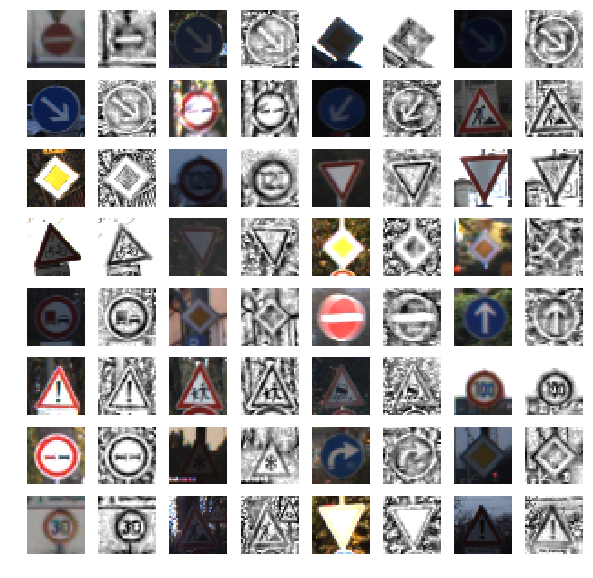

In [7]:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_train = preprocess_gray(X_train)
pickle.dump([X_train, y_train], open(train_preprocessed_file, "wb" ) )

X_test = preprocess_gray(X_test)
pickle.dump([X_test, y_test], open(test_preprocessed_file, "wb" ) )

plot_random_related_images(train['features'], X_train)

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Based on the random image previews, I noticed two things:
1. The datasets (train and test) consist of sequences of 30 video frames 
2. The images have very different brightness and low contrast in general

Based on that, I decided teh following preprocess steps:
- Convert the image from RGB to YUV and extract the Y component
- Apply histogram equalization (https://en.wikipedia.org/wiki/Histogram_equalization) to the Y component of the image, producing a noticeable contrast increase. In particular, we use the CLAHE (Contrast Limited Adaptive Histogram Equalizer) method.
- Get rid of the color components (UV) as they do not add noticeable improvement in the performance of the network. This is also consistent with findings in Sermanet & Lecun's paper. Anyway, the code in this notebook is prepared to support RGB/YUV images with minimal changes, so more testing should be advisable to confirm this statement.
- Normalize [0,255] -> [0,1] to ensure low weights in the net.

In [8]:
import cv2
import numpy as np

def rotate_image(img, angle=90, scale=1.0):
    y, x, c = img.shape
    
    M = cv2.getRotationMatrix2D((x/2,y/2),angle,scale)

    flags=cv2.INTER_LANCZOS4+cv2.WARP_FILL_OUTLIERS
    border=cv2.BORDER_REPLICATE

    if (c == 1):
        rimg = cv2.warpAffine(img.reshape(y,x),M,(x,y),flags=flags,borderMode=border).reshape(y,x,c)
    elif (c == 3):
        rimg = cv2.warpAffine(img,M,(x,y),flags=flags,borderMode=border)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return rimg

def flip_image(img, axis):
    y, x, c = img.shape
    if (c == 1):
        fimg = cv2.flip(img.reshape(y,x),axis).reshape(y,x,c)
    elif (c == 3):
        fimg = cv2.flip(img, axis)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return fimg

def flip_image_h(img):
    return flip_image(img, 0)

def flip_image_v(img):
    return flip_image(img, 1)

def flip_image_diag(img):
    y, x, c = img.shape
    if (c == 1):
        fimg = cv2.transpose(img.reshape(y,x)).reshape(y,x,c)
    elif (c == 3):
        fimg = cv2.transpose(img)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return fimg

def flip_image_diag2(img):
    return flip_image_diag(rotate_image_180(img))
    
def rotate_image_180(img):
    return rotate_image(img, 180)

def rotate_image_90(img):
    return rotate_image(img, 90)

def rotate_image_minus90(img):
    return rotate_image(img, -90)

def rotate_image_random(img, angle=15, scale=1.0):
    return rotate_image(img, np.random.uniform(-angle,angle), scale)

def translate_image_random(img, delta=6):
    y, x, c = img.shape
    
    M = np.float32([[1,0,np.random.randint(-delta,delta)],[0,1,np.random.randint(-delta,delta)]])

    flags=cv2.INTER_LANCZOS4+cv2.WARP_FILL_OUTLIERS
    border=cv2.BORDER_REPLICATE

    if (c == 1):
        rimg = cv2.warpAffine(img.reshape(y,x),M,(x,y),flags=flags,borderMode=border).reshape(y,x,c)
    elif (c == 3):
        rimg = cv2.warpAffine(img,M,(x,y),flags=flags,borderMode=border)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return rimg

def warp_image_random(img, delta=5):
    y, x, c = img.shape
    
    pts1 = np.float32([[0,0],[x,0],[x,y],[0,y]])
    pts2 = pts1 + np.array(np.random.randint(-delta, delta, size=(4,2)), dtype=np.float32)
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
        
    flags=cv2.INTER_LANCZOS4+cv2.WARP_FILL_OUTLIERS
    border=cv2.BORDER_REPLICATE
    
    if (c == 1):
        pimg = cv2.warpPerspective(img.reshape(y,x),M,(x,y),flags=flags,borderMode=border).reshape(y,x,c)
    elif (c == 3):
        pimg = cv2.warpPerspective(img,M,(x,y),flags=flags,borderMode=border)
    else:
        raise(ValueError("Image must have 1 or 3 colors"))
    return pimg

def gaussian_noise_image(img, mean = 0, stddev = 5):
    y, x, c = img.shape
    noisy = np.random.normal(mean,stddev,(y, x, c)) + img
    return noisy

def saltnpepper_noise_image(img, prob = 0.01):
    y, x, c = img.shape
    rnd = np.random.rand(y, x, c)
    noisy = np.copy(img)
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 255
    return noisy

Augmenting training set leveraging left-right symmetries with 4649 more samples
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
Augmenting training set with 58052 more samples
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


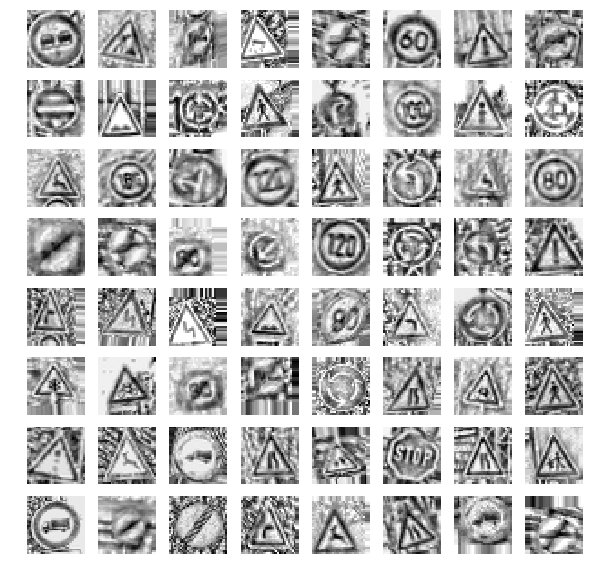

In [39]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
    
with open(train_preprocessed_file, mode='rb') as f:
    X_train, y_train = pickle.load(f)
    
prep_image_shape = X_train.shape[1:]

transforms_lr = [
    -1, #0,Speed limit (20km/h)
    -1, #1,Speed limit (30km/h)
    -1, #2,Speed limit (50km/h)
    -1, #3,Speed limit (60km/h)
    -1, #4,Speed limit (70km/h)
    -1, #5,Speed limit (80km/h)
    -1, #6,End of speed limit (80km/h)
    -1, #7,Speed limit (100km/h)
    -1, #8,Speed limit (120km/h)
    -1, #9,No passing
    -1, #10,No passing for vehicles over 3.5 metric tons
    -1, #11,Right-of-way at the next intersection
    -1, #12,Priority road
    -1, #13,Yield
    -1, #14,Stop
    -1, #15,No vehicles
    -1, #16,Vehicles over 3.5 metric tons prohibited
    -1, #17,No entry
    -1, #18,General caution
    20, #19,Dangerous curve to the left
    19, #20,Dangerous curve to the right
    -1, #21,Double curve
    -1, #22,Bumpy road
    -1, #23,Slippery road
    -1, #24,Road narrows on the right
    -1, #25,Road work
    -1, #26,Traffic signals
    -1, #27,Pedestrians
    -1, #28,Children crossing
    -1, #29,Bicycles crossing
    -1, #30,Beware of ice/snow
    -1, #31,Wild animals crossing
    -1, #32,End of all speed and passing limits
    34, #33,Turn right ahead
    33, #34,Turn left ahead
    -1, #35,Ahead only
    37, #36,Go straight or right
    36, #37,Go straight or left
    39, #38,Keep right
    38, #39,Keep left
    -1, #40,Roundabout mandatory
    -1, #41,End of no passing
    -1 #42,End of no passing by vehicles over 3.5 metric tons
]

hvalues, hbins = np.histogram(y_train, bins=n_classes)

n_samples_auglr = 0
for c in range(n_classes):
    if (transforms_lr[c] != -1):
        n_samples_auglr += hvalues[c]
        
X_train_auglr = np.empty([n_samples_auglr, prep_image_shape[0], prep_image_shape[1], prep_image_shape[2]])
y_train_auglr = np.empty([n_samples_auglr])
      
print("Augmenting training set leveraging left-right symmetries with {} more samples".format(n_samples_auglr))
i = 0
for c in range(n_classes):
    X_temp = X_train[y_train == c]
    n_samples = X_temp.shape[0]
    if (transforms_lr[c] != -1):
        for j in range(n_samples):
            X_train_auglr[i] = flip_image_v(X_temp[j])
            y_train_auglr[i] = transforms_lr[c]
            i += 1
    print_progress(c+1, n_classes)

X_train = np.append(X_train, X_train_auglr, axis=0)
y_train = np.append(y_train, y_train_auglr, axis=0)

hvalues, hbins = np.histogram(y_train, bins=n_classes)

n_samples = X_train.shape[0]
deltas = hvalues.max() - hvalues

identity_transforms = [
    [], #0,Speed limit (20km/h)
    [flip_image_h], #1,Speed limit (30km/h)
    [], #2,Speed limit (50km/h)
    [], #3,Speed limit (60km/h)
    [], #4,Speed limit (70km/h)
    [flip_image_h], #5,Speed limit (80km/h)
    [], #6,End of speed limit (80km/h)
    [], #7,Speed limit (100km/h)
    [], #8,Speed limit (120km/h)
    [], #[flip_image_v], #9,No passing
    [], #10,No passing for vehicles over 3.5 metric tons
    [flip_image_v], #11,Right-of-way at the next intersection
    [flip_image_h, flip_image_v, rotate_image_180, flip_image_diag, flip_image_diag2, rotate_image_90, rotate_image_minus90], #12,Priority road
    [flip_image_v], #13,Yield
    [], #14,Stop
    [flip_image_h, flip_image_v, rotate_image_180, flip_image_diag, flip_image_diag2, rotate_image_90, rotate_image_minus90], #15,No vehicles
    [], #16,Vehicles over 3.5 metric tons prohibited
    [flip_image_v, flip_image_h, rotate_image_180], #17,No entry
    [flip_image_v], #18,General caution
    [], #19,Dangerous curve to the left
    [], #20,Dangerous curve to the right
    [], #21,Double curve
    [flip_image_v], #22,Bumpy road
    [], #23,Slippery road
    [], #24,Road narrows on the right
    [], #25,Road work
    [flip_image_v], #26,Traffic signals
    [], #27,Pedestrians
    [], #28,Children crossing
    [], #29,Bicycles crossing
    [flip_image_v], #30,Beware of ice/snow
    [], #31,Wild animals crossing
    [flip_image_diag, flip_image_diag2, rotate_image_180], #32,End of all speed and passing limits
    [], #33,Turn right ahead
    [], #34,Turn left ahead
    [flip_image_v], #35,Ahead only
    [], #36,Go straight or right
    [], #37,Go straight or left
    [flip_image_diag], #38,Keep right
    [flip_image_diag2], #39,Keep left
    [rotate_image_90, rotate_image_minus90, rotate_image_180], #40,Roundabout mandatory
    [], #41,End of no passing
    [] #42,End of no passing by vehicles over 3.5 metric tons
]

# Check transformations are correct
#for c in range(n_classes):
#    X_temp = random.choice(X_train[y_train == c])
#    n_transforms = len(transforms[c])
#    if (n_transforms):
#        fig, axes = plt.subplots(1,n_transforms + 1, figsize=(10,1))
#        plot_image(X_temp, axes.flat[0])
#        for i,transform in enumerate(transforms[c]):
#            plot_image(transform(X_temp), axes.flat[i+1])
#        plt.show()
        
random_transforms = [rotate_image_random, translate_image_random, warp_image_random]#, saltnpepper_noise_image]

n_samples_aug = sum(deltas)
X_train_aug = np.empty([n_samples_aug, prep_image_shape[0], prep_image_shape[1], prep_image_shape[2]])
y_train_aug = np.empty([n_samples_aug])

i = 0
print("Augmenting training set with {} more samples".format(n_samples_aug))
print_progress(0, n_classes)

for c in range(n_classes):
    X_temp = X_train[y_train == c]
    n_samples = X_temp.shape[0]
    aug_per_sample = deltas[c] // n_samples
    aug_per_sample_mod = deltas[c] % n_samples
    for j in range(n_samples):
        for k in range(aug_per_sample):
            if k < len(identity_transforms[c]):
                X_train_aug[i] = identity_transforms[c][k](X_temp[j])
            else:
                X_train_aug[i] = random_transforms[k % len(random_transforms)](X_temp[j])
            y_train_aug[i] = c
            i += 1
        if (j < aug_per_sample_mod):
            X_train_aug[i] = rotate_image_random(X_temp[j],15,1.2)
            y_train_aug[i] = c
            i += 1            
    print_progress(c+1, n_classes)

assert(i == n_samples_aug)

X_train_aug = np.append(X_train_aug, X_train_auglr, axis=0)
y_train_aug = np.append(y_train_aug, y_train_auglr, axis=0)

pickle.dump([X_train_aug, y_train_aug], open(train_augmented_file, "wb" ) )

plot_random_images(X_train_aug)

Shuffling training set...
Shuffling test set...
Creating validation set from training set...
Normalizing input images before feeding the net...


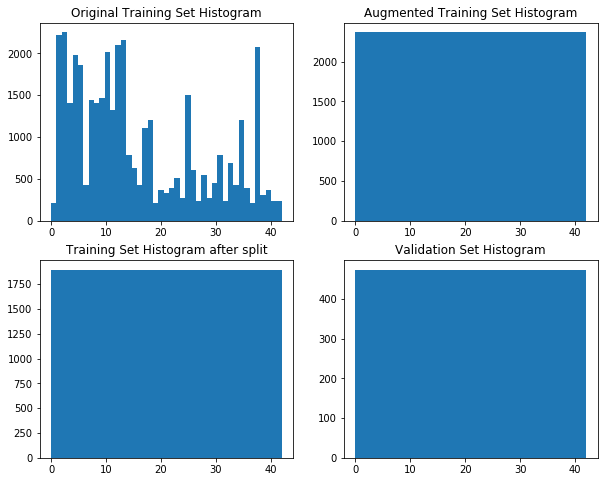

In [40]:
with open(train_augmented_file, mode='rb') as f:
    X_train_aug, y_train_aug = pickle.load(f)
with open(train_preprocessed_file, mode='rb') as f:
    X_train, y_train = pickle.load(f)
with open(test_preprocessed_file, mode='rb') as f:
    X_test, y_test = pickle.load(f)
    
fig = plt.figure(figsize=(10,8))
a=fig.add_subplot(2,2,1)
a.hist(y_train, n_classes, normed=0)
a.set_title("Original Training Set Histogram")

X_train = np.append(X_train, X_train_aug, axis=0)
y_train = np.append(y_train, y_train_aug, axis=0)

a=fig.add_subplot(2,2,2)
a.hist(y_train, n_classes, normed=0)
a.set_title("Augmented Training Set Histogram")

print("Shuffling training set...")
X_train, y_train = shuffle(X_train, y_train)
print("Shuffling test set...")
X_test, y_test = shuffle(X_test, y_test)

print("Creating validation set from training set...")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2017, stratify=y_train)

a=fig.add_subplot(2,2,3)
a.hist(y_train, n_classes, normed=0)
a.set_title("Training Set Histogram after split")
a=fig.add_subplot(2,2,4)
a.hist(y_val, n_classes, normed=0)
a.set_title("Validation Set Histogram")

print("Normalizing input images before feeding the net...")
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Based on the plotted histograms of the train and test sets, it is clear that the distribution of classes is quite unbalanced (e.g. "Keep Right" has over 2000 samples, whereas "Keep left" has only a few hundreds). Then, my main objective with data augmentation was to balance the  number of samples per class.

The steps to augment training samples are the following:
1. Leverage left-right signs symmetry to increase the number of samples (e.g. Keep Left = FlipVertical(Keep Right))
2. Based on the histogram after applying the previous step, generate samples until the number of samples per class reaches the maximum number of samples per class of the original training set. Samples are generated using the following approach:
    1. Leverage sign symmetry to produce samples of the same class, using these transformations:
        + Flip vertical
        + Flip horizontal
        + Flip diagonal 1
        + Flip diagonal 2
        + Rotate +90 degrees
        + Rotate -90 degrees
        + Rotate 180 degrees
    2. Apply as many random transformations as needed to balance the set:
        + random rotations (+-15 degrees)
        + random translation (+- 6 pixels)
        + random perspective warping (+- 5 pixels)

The new training set containing the original preprocessed samples plus the new augmented samples is then shuffled. The validation set is obtained randomly from the augmented training set (20% of original training samples).

Please note that up until now we are working with 32x32 byte images, which makes processing way much faster. We also avoid array appends while generating augmented images for performance reasons too. At this point we normalize all the images in the data sets, which converts the image into 32x32 float32 arrays, with values between 0 and 1.

>**Note**: In order to improve the split between the validation and training sets, we could build the validation set with full sequences of video frames (30 images per sequence). In this case, the training and the validation set must be splitted before applying data augmentation. This ensures that frames of the same sequence will only be present in either the training or the validation set, therefore making a validation set closer to the test set and better to tune the network.

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv_layer(x, W, b, strides=1):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME'), b))

def pool_layer(x, k, kp=1.0):
    return tf.nn.dropout(tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID'),kp)

def fc_output_layer(x, W, b):
    return tf.add(tf.matmul(x,W), b)

def fc_hidden_layer(x, W, b, kp=1.0):
    return tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(x,W), b)),kp)

def init_normal_weights(name, shape, reg_param):
    return tf.get_variable(name, 
                           shape=shape, 
                           initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                           regularizer=tf.contrib.layers.l2_regularizer(reg_param))

def init_xavier_weights(name, shape, reg_param):
    return tf.get_variable(name, 
                           shape=shape, 
                           initializer=tf.contrib.layers.xavier_initializer(), 
                           regularizer=tf.contrib.layers.l2_regularizer(reg_param))


def SermaNet(x, num_feat1, num_feat2, num_feat3, keep_prob, reg_param):    
    
    weights = {
        'wc1': init_xavier_weights('wc1', [5, 5, prep_image_shape[2], num_feat1], 0.0),
        'wc2': init_xavier_weights('wc2', [5, 5, num_feat1, num_feat2], 0.0),
        'wd3': init_xavier_weights('wd3', [num_feat1*8*8+num_feat2*4*4, num_feat3], reg_param),
        'wd4': init_xavier_weights('wd4', [num_feat3, n_classes], reg_param)}

    biases = {
        'bc1': tf.Variable(tf.zeros(num_feat1)),
        'bc2': tf.Variable(tf.zeros(num_feat2)),
        'bd3': tf.Variable(tf.zeros(num_feat3)),
        'bd4': tf.Variable(tf.zeros(n_classes))}
        
    # Layer 1: Convolutional. Input = 32x32xN. Output = 32x32xF1.
    layer1 = conv_layer(x, weights['wc1'], biases['bc1'])
        
    # Pooling. Input = 32x32xF1. Output = 8x8xF1.
    layer1 = pool_layer(layer1, 4, keep_prob)
    
    # Layer 2: Convolutional. Output = 8x8xF1. Output = 8x8xF2.
    layer2 = conv_layer(layer1, weights['wc2'], biases['bc2'])

    # Pooling. Input = 8x8xF2. Output = 4x4xF2.
    layer2 = pool_layer(layer2, 2, keep_prob)

    # Flatten. Input = 4x4xF2,8x8xF1 Output = 16*(F2+2*F1)
    layer2 = tf.concat(1,[flatten(layer2), flatten(layer1)])
    
    # Layer 3: Fully Connected. Input = 16*(F2+2*F1). Output = F3.
    layer3 = fc_hidden_layer(layer2, weights['wd3'], biases['bd3'], keep_prob)
    
    # Layer 4: Fully Connected. Input = F3. Output = n_classes.
    logits = fc_output_layer(layer3, weights['wd4'], biases['bd4'])
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I implemented a model similar to the one presented in Sermanet & LeCun's paper, with the following layer architecture and connectivity:
- Input (32x32x1)
- Conv Layer (5x5x128, stride 1 to 32x32x128)
- Relu
- Maxpool (with added drop-out) (4x4 kernel, 4x4 stride to 8x8x128) -> S1
- Conv Layer (5x5x256, stride 1 to 8x8x256)
- Relu
- Maxpool (with added drop-out) (2x2 kernel, 2x2 stride to 4x4x256) -> S2
- Flatten (S2 + S1, 4x4x256+8x8x128=12288 nodes)
- Fully Connected (with added drop-out) (12288 -> 512)
- Relu
- Output (512 -> 43)

Total number of params (weights + biases): 7136811

![Sermanet](sermanet.png)

In [41]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 40
BATCH_SIZE = 256
LEARNING_RATE = 0.001
REG_RATE = 0.0005
DROPOUT_KEEP_PROB = 0.75
MODEL_FEATURES = (128, 256, 512)

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, prep_image_shape[0], prep_image_shape[1], prep_image_shape[2]))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
reg_param = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

# Training pipeline
logits = SermaNet(x, MODEL_FEATURES[0], MODEL_FEATURES[1], MODEL_FEATURES[2], keep_prob, reg_param)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
L2_reg =  tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
loss_operation = tf.reduce_mean(cross_entropy)+L2_reg
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

# Cross-validation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluation(X_data, y_data):
    n_samples = X_data.shape[0]
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, n_samples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation, loss_operation], 
                                 feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, reg_param:0.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += loss
    return total_accuracy / n_samples, total_loss / n_samples

def get_trainable_params():
    n_params = 0
    for tfvar in tf.trainable_variables():
        n_params += int(np.prod(tfvar.get_shape()))
    return n_params

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_samples = X_train.shape[0]
    print("Training... with {} params and {} samples".format(get_trainable_params(), n_samples))
    start = time.time()
    for i in range(EPOCHS):
        start = time.time()
        for offset in range(0, n_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT_KEEP_PROB, reg_param:REG_RATE})
                    
        train_m, train_s = [int(x) for x in divmod(time.time() - start, 60)]
        
        train_accuracy, train_loss = evaluation(X_train, y_train)
        val_accuracy, val_loss = evaluation(X_val, y_val)

        eval_m, eval_s = [int(x) for x in divmod(time.time() - start, 60)]
        
        print("EPOCH {:>2d} Accuracy = {:4.2f}%/{:4.2f}% Loss = {:10.8f}/{:10.8f} Time = {:2d}m{:02d}s/{:2d}m{:02d}s".
              format(i+1, train_accuracy*100, val_accuracy*100, train_loss, val_loss, train_m, train_s, eval_m, eval_s))
        
    print()
    print("Testing...")
    test_accuracy,test_loss = evaluation(X_test, y_test)
    print("Testset Accuracy = {:4.2f}% Loss = {:10.8f}".format(test_accuracy*100, test_loss))

    saver.save(sess, "sermanet")
    print("Model saved")

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Training... with 7136811 params and 81528 samples
EPOCH  1 Accuracy = 86.41%/85.76% Loss = 0.00207844/0.00216163 Time =  0m39s/ 0m55s
EPOCH  2 Accuracy = 93.29%/92.43% Loss = 0.00102921/0.00113014 Time =  0m39s/ 0m55s
EPOCH  3 Accuracy = 95.95%/95.02% Loss = 0.00065408/0.00076339 Time =  0m39s/ 0m55s
EPOCH  4 Accuracy = 97.22%/96.24% Loss = 0.00045148/0.00055942 Time =  0m39s/ 0m55s
EPOCH  5 Accuracy = 97.38%/96.28% Loss = 0.00040447/0.00052405 Time =  0m39s/ 0m55s
EPOCH  6 Accuracy = 98.16%/97.02% Loss = 0.00030773/0.00042583 Time =  0m39s/ 0m55s
EPOCH  7 Accuracy = 98.80%/97.66% Loss = 0.00023223/0.00034500 Time =  0m39s/ 0m55s
EPOCH  8 Accuracy = 98.85%/97.66% Loss = 0.00020333/0.00032032 Time =  0m39s/ 0m55s
EPOCH  9 Accuracy = 99.12%/97.94% Loss = 0.00016657/0.00027731 Time =  0m39s/ 0m55s
EPOCH 10 Accuracy = 99.15%/97.93% Loss = 0.00016188/0.00027932 Time =  0m39s/ 0m55s
EPOCH 11 Acc

### Question 4
_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
To help tuning my network, I calculate and print out for each epoch the accuracy and the loss for the training and validation sets respectively. This allows me to notice when the network is overfitting (losses diverge) or underfitting (flat losses).

I trained my model changing some of the following hyperparameters:
- Batch size (256): I started with high values and found out that lower ones improve the performance.
- Optimizer (Adam): I am using the widely recommended Adam optimizer. I did try to change this one.
- Weight initialization (Xavier): This method is better if the number of layers is higher than in my model, but I used it anyway to improve convergence in the first epochs.
- Epochs (40): After inspecting too many training logs, I decided 40 was a good value to stop, as the gain in loss is insignificant from then on
- Learning rate (0.001): Standard value of the learning rate. Considering the Adam optimizer adapts the learning rate as it trains, I believe tuning this parameter has minimal impact. 
- Regularization (0.0005): Regularization is a valuable method to avoid overfitting by forcing the weights to take lower values. The regularization penalty hyperparameter depends on the number of weights. However it is only applied on the last fully connected layers.
- Dropout (25%): After several trials, I noticed the network performed consistently better with a dropout of 25% (keep probability of 0.75 based on tensorflow naming). I did not set different probabilities based on the layer, although I recognize it could help to have lower dropout in the first layers (again, higher keep probability values).    
- Model features (F1=128 F2=256 F3=512): After much trial and error with the feature values inferred from Sermanet & Lecun's paper, I decided to increase the number of features for best performance.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with Lenet-5 as suggested, but soon found out that I had to increase the number of features in order to achieve a decent performance on the test set. Then I decided to try with Sermanet as described in Sermanet & Lecun's paper on traffic signs. I decided to stay with Sermanet as performance was better the paper accuracy numbers were a solid reference to aim to. 

Anyway I feel the process of finding the most promising model for a particular problem is never ending. The combinations are too huge to test them all, so I guess that intuition after lots of experience helps in finding the best combination much faster. Based on the experience I gained by doing this project (my first deep learning!), I believe next steps to improve performance would be to add more layers to the model, ideally a new convolutional layer and another fully connected one.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Preprocessing dataset with 30 samples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


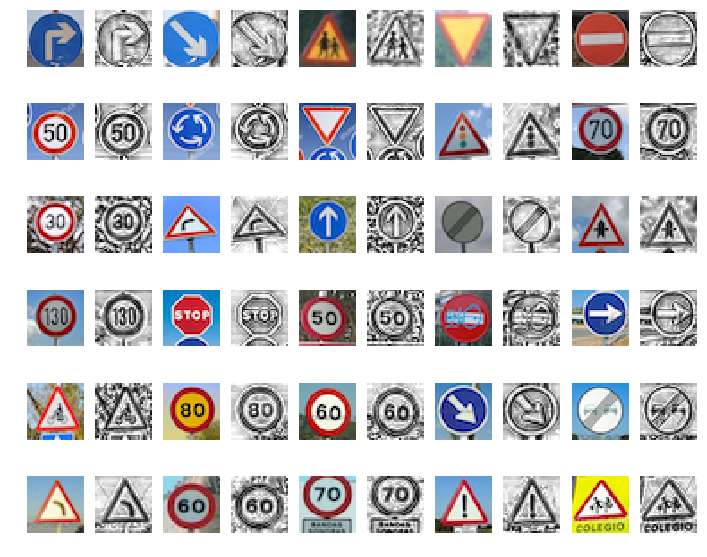

In [42]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


custom_folder = "traffic-signs-data/extra/"

X_extra_orig = np.empty((0,32,32,3), 'uint8')

for imgname in sorted(os.listdir(custom_folder)):
    item = mpimg.imread(custom_folder + imgname)
    item = (item * 255).astype('uint8')
    item = np.reshape(item, (1,32,32,3))
    X_extra_orig = np.append(X_extra_orig, item, axis=0)

n_extra = X_extra_orig.shape[0]
X_extra = normalize(preprocess_gray(X_extra_orig))
y_extra = np.array([33, 38, 28, 13, 17, 2, 40, 13, 26, 4, 1, 20, 35, 32, 11, 8, 14, 2, 17, 38, 29, 5, 3, 38, 41, 19, 3, 4, 18, 28])

fig, axes = plt.subplots(6,10, figsize=(12,10))
axes = axes.flat
for i in range(n_extra):
    plot_image(X_extra_orig[i], axes[2*i])
    plot_image(X_extra[i], axes[2*i+1])
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I selected 30 images (plotted above) for this exercise. In order to make the task more difficult:
- Most of the signs are from a different country (Spain)
- Some signs have a yellow background instead of the standard white
- One sign is affected by urban art (spray-painted)
- Some signs belong to non-trained classes (e.g. 130 speed limit)
- One image has an impossible perspective (e.g. dangerous curve to right)
- One image is cut (e.g. 70 speed limit)

In [43]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
new_saver = tf.train.import_meta_graph('sermanet.meta')

top_k_operation = tf.nn.top_k(tf.nn.softmax(logits), 5)

with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint("."))
    
    topk_predictions = sess.run(top_k_operation, feed_dict={x: X_extra, y: y_extra, keep_prob: 1.0, reg_param:0.0})
    
    extra_accuracy,extra_loss = evaluation(X_extra, y_extra)
    print("Extra Set Accuracy = {:4.2f}% Loss = {:10.8f}".format(extra_accuracy*100, extra_loss))

Extra Set Accuracy = 73.33% Loss = 0.05501875


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The performance of the model dramatically decreases when testing images from unrelated datasets like the ones above. Here are some examples:
- The model fails very often with speed limit signs. I believe changes in font and number thickness may be the culprits.
- The loss is quite high when compared with the test set, meaning that even though the accuracy (73%) is not horrible, the uncertainty when predicting a sign class is much higher.


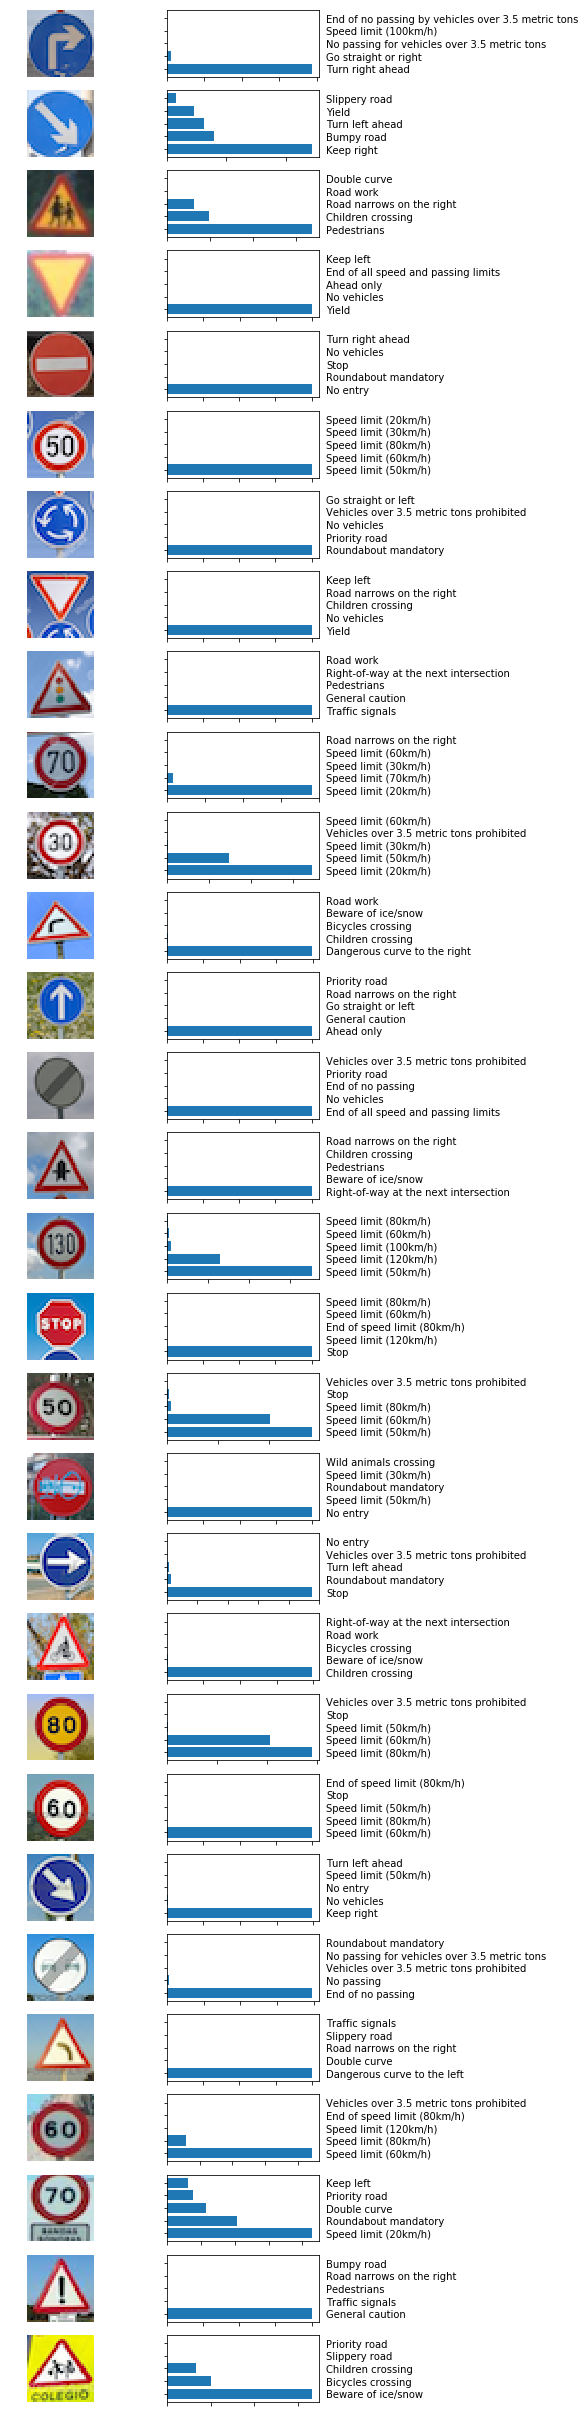

In [44]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

p_values, p_indexes = topk_predictions

n_items = X_extra_orig.shape[0]
k = p_values.shape[1]

fig, axes = plt.subplots(n_items,2, figsize=(6,44))

for i , ax in enumerate(axes.flat):
    if i % 2:
        ax.barh(np.arange(k)+.5, p_values[i//2], align='center')
        ax.set_yticks(np.arange(k)+.5)
        ax.set_yticklabels(np.array(signnames)[p_indexes[i//2].astype(int)])
        ax.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')            
    else:
        ax.set_axis_off()
        ax.imshow(X_extra_orig[i//2])

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
I found the following insights:
- For most of the signs that were correctly predicted, the predicted class have a very high certainty. The only exceptions are some speed limit predictions.
- It is strange and a bit scary to classify the arrow pointing to the right as an stop with such a high certainty. For non-trained traffic sign classes I would expect a top 5 predictions with similar probabilities.
- All the signs that were incorrectly predicted, the correct class was in the top 5 predictions. The only exception is the clipped 70 speed limit.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.